# 用户指南，第6章：流(II)：分层，递归与展平
[原文链接](https://www.music21.org/music21docs/usersGuide/usersGuide_06_stream2.html#usersguide-06-stream2)

在[第4章](04.ipynb)中，我们创建了一个嵌套的`Stream`对象。这里我们先把它重新创建出来

In [62]:
from music21 import *

note1 = note.Note("C4")
note1.duration.type = 'half'
note2 = note.Note("F#4")
note3 = note.Note("B-2")

stream1 = stream.Stream()
stream1.id = 'some notes'
stream1.append(note1)
stream1.append(note2)
stream1.append(note3)

biggerStream = stream.Stream()
note2 = note.Note("D#5")
biggerStream.insert(0, note2)
biggerStream.append(stream1)

到目前为止，如果要查看内层`Stream`内容，我们只介绍了`.show('text')`

In [63]:
biggerStream.show('text')

{0.0} <music21.note.Note D#>
{1.0} <music21.stream.Stream some notes>
    {0.0} <music21.note.Note C>
    {2.0} <music21.note.Note F#>
    {3.0} <music21.note.Note B->


如[第4章](4.ipynb)所说，使用`biggerStream[1][1]`这种语法，可以获取`F#`等内层音符。但是music21中有一种更好的方式。为此，我们要学习子类的基本概念，以及Stream的子类。（如果你已经知道了，可以跳过。）

## 类和子类
对象，例如note或pitch，包含一组信息，以及可以对该信息执行的一些操作。类是用于定义与创建生成新对象的类型。我们已经见过了`note.Note`等类，其中，大写的`Note`类名位于小写的`note`库中。

In [64]:
note

<module 'music21.note' from 'E:\\repos\\music21\\music21\\note.py'>

In [65]:
print(note.Note)

<class 'music21.note.Note'>


在类名后紧跟着一对括号`()`，以创建对象

In [66]:
n=note.Note()
n

<music21.note.Note C>

可以在括号中加入信息，例如音名。

In [67]:
d=note.Note('D#5')
d

<music21.note.Note D#>

现在`d`是一个从`Note`类创建的`Note`对象。我知道这可能有些迷惑，但是接下来就带你弄清楚。如果你想知道`Note`还能做什么，最好的办法是阅读music21手册。:-) 除此之外，对于Python中的任何一个类，你都可以使用函数`help(Class)`来获得这个类的使用方法。

In [68]:
#以下代码会输出大量文本，请删除井号运行
#help(note.Note)

注意在最上方有一条`class Note(NotRest)`行。这说明`Note`是`NotRest`的子类。`NotRest`包含所有“类似于音符的东西”，例如`Note`、`Unpitched`和`Chord` ，但不包括休止符。（我和 Chris Ariza 花了一个多小时试图为这些事物想出一个更好的名字，但最终我们没能想出一个比`NotRest`更好的名字，所以最终选择了`NotRest`）。

`Note`是`NotRest`的子类，这意味着：任何`NotRest`能做的事情，`Note`都能做。除此之外，一些`NotRest`不能做的事情，`Note`也能做。例如，`NotRest`有`beams`属性，`Note`也有

In [69]:
nr = note.NotRest()
n = note.Note()
print(nr.beams, n.beams)

<music21.beam.Beams> <music21.beam.Beams>


但是`Rest`显然不是`NotRest`的子类，它就没有`beams`属性。

In [70]:
r = note.Rest()
r.beams

AttributeError: 'Rest' object has no attribute 'beams'

除此之外，`Note`还包含一些`NotRest`没有的属性，例如`pitch`。

In [71]:
print(nr.pitch)

AttributeError: 'NotRest' object has no attribute 'pitch'

所以，类和子类是描述具有相似特性的一系列事物的有效方式。但是它们也能拥有自己独特的信息（属性）和行为（方法）。

（仅供参考）以下是创建子类的方式。我们先创建一个类叫做`Japan`，然后创建一个子类叫做`Okinawa`（这是我的祖籍），该子类拥有更多属性。

In [72]:
class Japan:
    food = "sushi"
    drink = "sake"

class Okinawa(Japan):
    evenBetterFood = "spam potstickers"

`Onikawa`类定义中的`(Japan)`说明它继承了`Japan`拥有的一切，除此之外还有自己的独特内容

In [73]:
o = Okinawa()
print(o.food, o.drink, o.evenBetterFood)

sushi sake spam potstickers


但是`Japan`就没有这些独特内容

In [74]:
j = Japan()
print(j.evenBetterFood)

AttributeError: 'Japan' object has no attribute 'evenBetterFood'

这就是子类的工作方式。下面我们即将接触到`Stream`的三种基本的子类：总谱`Score`、音轨`Part`和小节`Measure`

## 访问总谱`Score`、音轨`Part`、小节`Measure`和音符`Note`
`Stream`提供了一种方法来结构化地表达`music21`对象。一个`Stream`，或者`Stream`子类（例如`Measure`），可以存入另一个`Stream`。

一种常见的对象配置是：一个`Score`包含多个`Part`，每个`Part`又包含多个`Measure`。

这种对象配置是在music21中表示乐谱的常用形式。例如，导入一首巴赫的四音轨众赞歌，会得到一个乐谱，含有四个`Part`，每个`Part`含有多个`Measure`。music21自带一个`music21.corpus`（乐谱库），包含大量的乐谱，包括全部的巴赫众赞歌。我们可以使用`parse()`导入乐谱。

In [75]:
sBach = corpus.parse('bach/bwv57.8')

使用标准的python嵌套列表语法，可以访问这个乐谱中各个层次的元素。由此，可以查看每个元素的长度：总谱含有六个元素：一个`Metadata`，一个`StaffGroup`和四个`Part`。位于编号3的音轨含有14个元素（其中13个是小节）。其中，位于编号1的对象是小节。所有这些对象都可以从`sBach`中访问到。

In [76]:
len(sBach)

9

In [77]:
len(sBach[3])

14

In [78]:
len(sBach[3][1])

7

但是怎么知道`sBach[3]`是音轨，`sBach[3][1]`是小节呢？我们作为教程作者当然知道，但是正如上面所说的，`Part`里面不只存`Measure`（例如还有`Instrument`对象），`Measure`也不只存`Note`和`Rest`（例如`TimeSignature`和`KeySignature`）。因此，需要对`Stream`进行过滤。

使用`.getElementsByClass()`以获取指定类型的对象。

In [79]:
len(sBach.getElementsByClass(stream.Part))

4

In [80]:
len(sBach.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure))

13

In [81]:
len(sBach.getElementsByClass(stream.Part)[0].getElementsByClass(
        stream.Measure)[1].getElementsByClass(note.Note))

3

记得[第4章](4.ipynb)讲过，`.getElementsByClass()`也支持用类名字符串来过滤。所以上面的代码也可以写做：

In [82]:
len(sBach.getElementsByClass('Part'))

4

这种方式比输入类型对象写起来方便一些，但是没那么安全。例如，如果同时含有`stream.Measure`和`tape.Measure`对象，用字符串过滤就不能区分这两种对象（但是这种情况很少见，所以大多数时候是安全的）

在`.getElementsByClass()`函数的基础上，还引入了`.notes`和`.notesAndRests`属性。同样，可以用`.parts`过滤出音轨对象。

In [83]:
len(sBach.parts)

4

你可能会想有一个`.measures`属性来获取小节对象。但是问题在于小节序号和`Stream`中的索引不一样。例如，大部分乐谱（没有弱起小节）以第1小节开始，而不是第0小节。有时候小节数不是连续增长的（例如，有些人把第一个和第二个小节编为同样的小节序号）。所以，把小节过滤出来的最佳方法是`getElementsByClass(stream.Measure)`。

而`.measures()`用来选出指定的小节序号区间，`.measure()`用来选出指定的小节序号。不过请注意：
1. 这两个都是函数而不是属性，所以要用括号调用
2. `.measures()`选出的区间既包含开始序号，也包含结束序号。这和python的列表切片不一样。

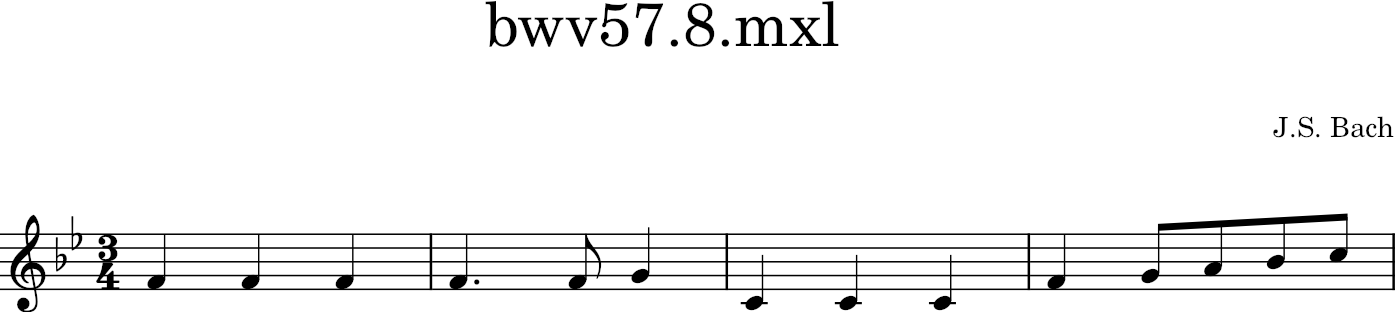

In [84]:
alto = sBach.parts[1]  # parts count from zero, so soprano is 0 and alto is 1
excerpt = alto.measures(1, 4)
excerpt.show()

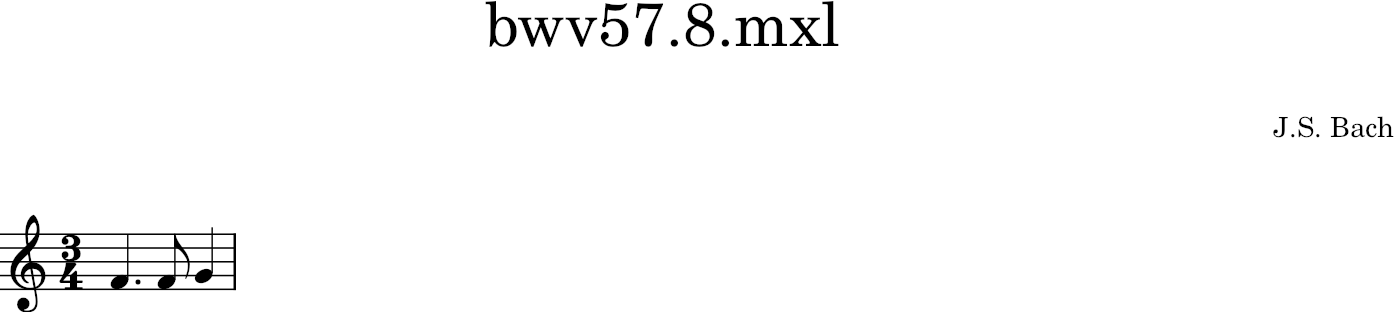

In [85]:
measure2 = alto.measure(2)  # measure not measure_s_
measure2.show()

`.measure()`和`.measures()`不仅适用于单个音轨，还适用于整个乐谱。计算机音乐学家和程序员有时候会把多音轨的小节叫做"measureStack"。下面来获取`sBach`中所有音轨的第2、3小节

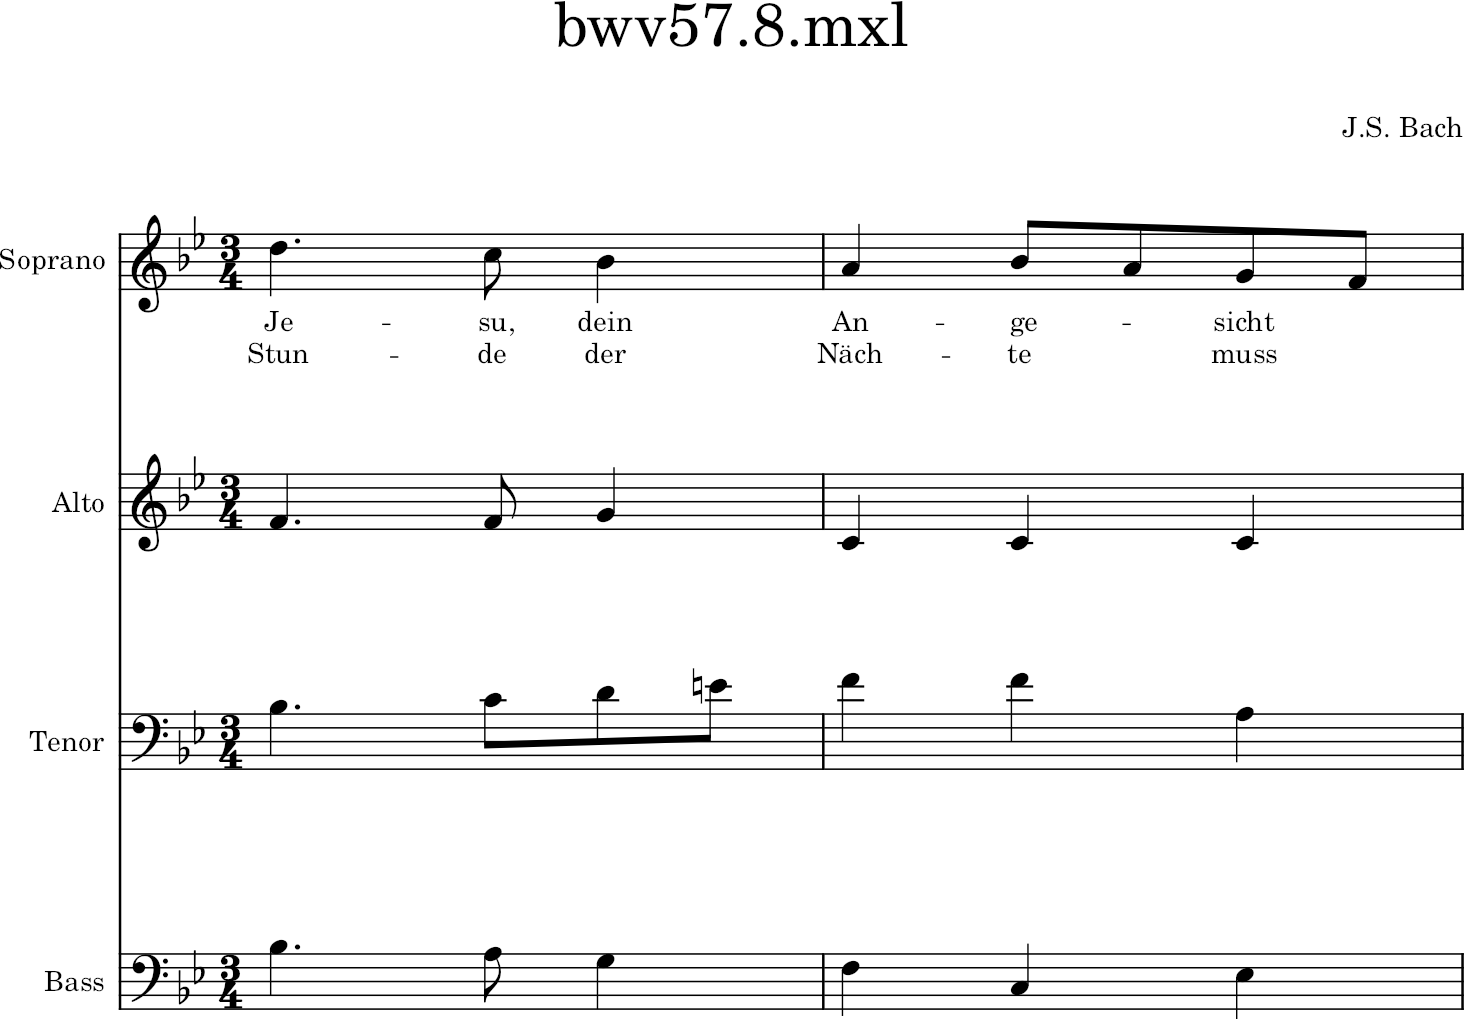

In [86]:
measureStack = sBach.measures(2, 3)
measureStack.show()

## 在`Stream`中递归

`Stream`自身可以包含`Stream`。提供了一个`recurse()`来遍历`Stream`中各个层级的对象。具体来说，从`Stream`的开头开始，如果子元素也是`Stream`，则进入这个子元素并遍历。

创建一个简单的多层`Stream`来看看`.recurse()`会做什么。

In [87]:
s = stream.Score(id='mainScore')
p0 = stream.Part(id='part0')
p1 = stream.Part(id='part1')

m01 = stream.Measure(number=1)
m01.append(note.Note('C', type="whole"))
m02 = stream.Measure(number=2)
m02.append(note.Note('D', type="whole"))
p0.append([m01, m02])

m11 = stream.Measure(number=1)
m11.append(note.Note('E', type="whole"))
m12 = stream.Measure(number=2)
m12.append(note.Note('F', type="whole"))
p1.append([m11, m12])

s.insert(0, p0)
s.insert(0, p1)
s.show('text')

{0.0} <music21.stream.Part part0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.note.Note C>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note D>
{0.0} <music21.stream.Part part1>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.note.Note E>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note F>


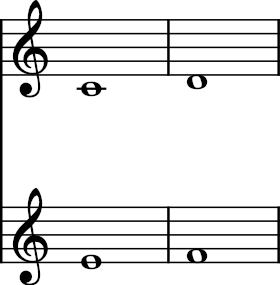

In [88]:
s.show()

如果直接调用`.recurse()`，看上去好像没有什么用

In [89]:
recurseScore = s.recurse()
recurseScore

<music21.stream.iterator.RecursiveIterator for Score:mainScore @:0>

但是如果放在for循环里面就有用了。

In [90]:
for el in s.recurse():
    print(el.offset, el, el.activeSite)

0.0 <music21.stream.Part part0> <music21.stream.Score mainScore>
0.0 <music21.stream.Measure 1 offset=0.0> <music21.stream.Part part0>
0.0 <music21.note.Note C> <music21.stream.Measure 1 offset=0.0>
4.0 <music21.stream.Measure 2 offset=4.0> <music21.stream.Part part0>
0.0 <music21.note.Note D> <music21.stream.Measure 2 offset=4.0>
0.0 <music21.stream.Part part1> <music21.stream.Score mainScore>
0.0 <music21.stream.Measure 1 offset=0.0> <music21.stream.Part part1>
0.0 <music21.note.Note E> <music21.stream.Measure 1 offset=0.0>
4.0 <music21.stream.Measure 2 offset=4.0> <music21.stream.Part part1>
0.0 <music21.note.Note F> <music21.stream.Measure 2 offset=4.0>


这个例子同时也介绍了`.activeSite`的概念。目前你可以理解为：该元素所属的上级`Stream`。当然，`Notes`和其他元素可以同时属于多个`Stream`，而`.activeSite`是最近与它发生关系的那个`Stream`。

用`.recurse()`可以实现很多功能，但是这里我们先介绍一件事：大多数“过滤”操作，例如`.notes`，都可以对`.recurse()`使用

In [91]:
for el in s.recurse().notes:
    print(el.offset, el, el.activeSite)

0.0 <music21.note.Note C> <music21.stream.Measure 1 offset=0.0>
0.0 <music21.note.Note D> <music21.stream.Measure 2 offset=4.0>
0.0 <music21.note.Note E> <music21.stream.Measure 1 offset=0.0>
0.0 <music21.note.Note F> <music21.stream.Measure 2 offset=4.0>


注意：`.recurse()`是python中的“生成器”对象。因此，它只能用于for循环，或其他遍历场景，而不能像list一样使用。如果想像list一样使用，请把它显式地转换为list。
```py
listRecurse = list(sBach.recurse())
```

## 扁平化
虽然嵌套的`Stream`拥有强大的表达能力，但是很多时候我们只需要单个`Stream`装有所有的非`Stream`对象。`flatten()`函数就提供了这种功能。例如，如果要对音符计数，我们就可以通过`flat`访问音符。由于历史原因，`flat`是属性，所以不需要在后面带一对括号`()`。

我们来看看对同样的乐谱用`.flatten()`会怎样

In [92]:
for el in s.flatten():
    print(el.offset, el, el.activeSite)

0.0 <music21.note.Note C> <music21.stream.Score mainScore_flat>
0.0 <music21.note.Note E> <music21.stream.Score mainScore_flat>
4.0 <music21.note.Note D> <music21.stream.Score mainScore_flat>
4.0 <music21.note.Note F> <music21.stream.Score mainScore_flat>


创建了一个新的`Stream`，id为"mainScore_flat"，包含了所有的音符。`.flat`自动移除了所有的`Stream`对象。

现在所有的音符都包含在这个新的`Stream`中，它们的时刻不再是0.0，而是以新`Stream`的开头为基准来衡量`Stream`。所以，第2小节的全音符的时刻为4.0

而如果把`.flatten()`作用于一个更大的乐谱会怎么样呢？

`sBach`中并不直接含有音符

In [93]:
len(sBach.getElementsByClass(note.Note))

0

这些音符在`sBach`中的`Part`中的`Measures`里面（对于更复杂的乐谱，甚至可能在`Score`中的`Part`中的`Measures`中的`Voice`里面）。但是它们都在扁平化的`Stream`中：

In [94]:
len(sBach.flatten().getElementsByClass(note.Note))

150

元素的时刻永远基于直接包含该元素的`Stream`。例如，`Stream`中的一个小节，其时刻为16，这是小节开头相对于`Stream`开头的时间差。而这个小节中的元素，例如`Note`，其时刻是这个元素相对于小节开头的时间差。例如，小节的第一个音符的时刻为0.在下面的例子中，第8小节的时刻（` getOffsetBySite()`）为21，而第8小节的第二个音符（索引为1）的时刻为1。

In [95]:
m = sBach.parts[0].getElementsByClass('Measure')[7]
m.getOffsetBySite(sBach.parts[0])

21.0

In [96]:
n = sBach.parts[0].measure(8).notes[1]
n

<music21.note.Note E->

In [97]:
n.getOffsetBySite(m)

1.0

将一个嵌套结构扁平化会为每个元素赋予新的，平移的时刻，反映了它相对于整个大`Stream`的时间差。例如，上面的乐谱扁平化后，该音符的时刻为22（21+1）

In [98]:
pFlat = sBach.parts[0].flatten()
indexN = pFlat.index(n)
pFlat[indexN]

<music21.note.Note E->

In [99]:
pFlat[indexN].offset

22.0

注意这个音符的时刻没有被修改过，时刻之所以不一样，是因为音符可以同时属于多个`Stream`，并相对于每个`Stream`都有一个时刻。

关于`Stream`，仍然有很多操作和属性值得学习，但我们先放在一边。下面我们来学习[第七章：和弦](07.ipynb)